In [100]:
from pathlib import Path
import re
import csv

import requests
import pandas as pd
import plotly.express as px

In [80]:
TICK_URL = 'https://www.mountainproject.com/user/112795239/ben-thornton/tick-export'
RE_YDS = re.compile(r'5\.(\d{1,2})\s*([abcd\+])?\s*R?', flags=re.IGNORECASE)
RE_VERMIN = re.compile(r'V(\d{1,2})\s*R?', flags=re.IGNORECASE)

In [81]:
def get_subgrade(rating):
    if (match := RE_YDS.match(rating)) != None:
        try:
            groups = match.groups()
        except:
            pass
        if len(groups) < 2:
            return None
        else:
            return groups[1]
    
    elif match := RE_VERMIN.match(rating) != None:
        return None

    else:
        raise ValueError('Grade not recognized')            

def get_grade(rating):
    if (match := RE_YDS.match(rating)) != None:
        try:
            grade = int(match.groups()[0])
        except:
            pass
    
    elif (match := RE_VERMIN.match(rating)) != None:
        grade = int(match.groups()[0])

    else:
        raise ValueError('Grade not recognized')      
    
    return grade

In [103]:
df

,Date,Route,Style,Lead Style,Route Type,Grade,Subgrade,Year
1,2022-03-20,A Cat Amongst the Pigeons,Lead,Redpoint,Sport,12,a,2022
2,2022-03-20,A Cat Amongst the Pigeons,Lead,Fell/Hung,Sport,12,a,2022
3,2022-03-20,Tourist Attractions,Lead,Onsight,Sport,10,b,2022
4,2022-03-19,Like A Turtle,Lead,Flash,Sport,11,b,2022
5,2022-03-19,Two Women Alone,Lead,Onsight,Sport,11,a,2022
...,...,...,...,...,...,...,...,...
361,2017-08-27,Biohazard,TR,,Trad,10,a,2017
362,2017-08-26,Team Jesus,TR,,Trad,10,a,2017
363,2017-08-26,New River Gunks,Follow,,"Trad, TR",7,+,2017
364,2017-04-02,Surly Girl,,,TR,8,None,2017


In [163]:
# Read in the data from mountain project
df = pd.DataFrame(csv.reader(requests.get(TICK_URL).text.splitlines()))

# Set the first line as the header
df = df.set_axis(df.iloc[0], axis=1).iloc[1:]                

# Tweak the data
df = (df
      .assign(**{'Grade': df['Rating'].apply(get_grade)})                                 # Get the number grade (e.g. 11)
      .assign(**{'Subgrade': df['Rating'].apply(get_subgrade)})                           # Get the letter grade (e.g. a)
      .assign(**{'Date': pd.to_datetime(df['Date'])})                                     # Get the year of the send
      .assign(**{'Style': df['Style'].str.lower()})                                       # Change values to lowercase     
      .assign(**{'Lead Style': df['Lead Style'].str.lower()})                             # Change values to lowercase
      .assign(**{'Route Type': df['Route Type'].str.lower()})                             # Change values to lowercase 
      [['Date', 'Route', 'Style', 'Lead Style', 'Route Type', 'Grade', 'Subgrade']])      # Keep only certain columns

In [164]:
df

,Date,Route,Style,Lead Style,Route Type,Grade,Subgrade
1,2022-03-20,A Cat Amongst the Pigeons,lead,redpoint,sport,12,a
2,2022-03-20,A Cat Amongst the Pigeons,lead,fell/hung,sport,12,a
3,2022-03-20,Tourist Attractions,lead,onsight,sport,10,b
4,2022-03-19,Like A Turtle,lead,flash,sport,11,b
5,2022-03-19,Two Women Alone,lead,onsight,sport,11,a
...,...,...,...,...,...,...,...
361,2017-08-27,Biohazard,tr,,trad,10,a
362,2017-08-26,Team Jesus,tr,,trad,10,a
363,2017-08-26,New River Gunks,follow,,"trad, tr",7,+
364,2017-04-02,Surly Girl,,,tr,8,None


In [165]:
def get_first_sends(df, route_type=None):
    """Get a list of all the first-time sends.

    Parameters
    ----------
    df : DataFrame
        DataFrame of ticks
    route_type : str, optional
        Must be 'Sport', 'Trad', 'TR'. Set to None to return all., by default None

    Returns
    -------
    DataFrame
        DataFrame of first-time sends.
    """
    df = (df
          [(df['Style'] == 'lead') & (~df['Lead Style'].isin(['fell/hung', '']))]
          .drop_duplicates('Route')
          .sort_values('Date'))

    if route_type is not None:
        df = df[df['Route Type'].str.contains(route_type, flags=re.IGNORECASE)]

    return df


In [167]:
get_first_sends(df, 'sport')

,Date,Route,Style,Lead Style,Route Type,Grade,Subgrade
351,2018-04-14,The Upheaval,lead,flash,sport,9,None
350,2018-04-14,Strike A Scowl,lead,flash,sport,10,None
342,2018-05-12,The Offering,lead,onsight,sport,7,None
339,2018-05-12,Stay Off the Radio Jeff!,lead,redpoint,sport,9,+
343,2018-05-12,Bee's Business,lead,onsight,sport,8,None
...,...,...,...,...,...,...,...
6,2022-03-19,5.10 Until Lee and Jeff Do It,lead,flash,sport,9,+
5,2022-03-19,Two Women Alone,lead,onsight,sport,11,a
4,2022-03-19,Like A Turtle,lead,flash,sport,11,b
3,2022-03-20,Tourist Attractions,lead,onsight,sport,10,b


In [182]:
def mpl_hist(df, route_type=None):
    """Returns a matplotlib figure of a histogram of route difficulties grouped by year.

    Parameters
    ----------
    df : DataFrame
        DataFrame of ticks

    Returns
    -------
    Figure
        Histogram of route difficulties grouped by year
    """
    df = get_first_sends(df, route_type)
    bins = list(range(df['Grade'].min(), df['Grade'].max()+2))

    fig, ax = plt.subplots()
    for year in df['Date'].dt.year.unique()[::-1]:
        _ = df[df['Date'].dt.year==year].hist(column='Grade', bins=bins, ax=ax, label=year, alpha=0.75)

    ax.legend()

    return ax

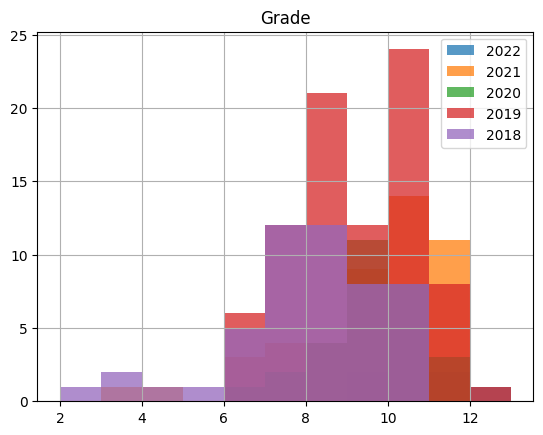

In [184]:
ax = mpl_hist(df)

In [196]:
def px_hist(df, route_type=None):
    df = get_first_sends(df, route_type)
    df['Year'] = df['Date'].dt.year
    fig = (px.histogram(df,
                        x='Grade',
                        nbins=int(df['Grade'].max() - df['Grade'].min()),
                        facet_row='Year',
                        width=1000,
                        height=1000,
                        color='Year',
                        range_x=[df['Grade'].min(), df['Grade'].max()],
                        range_y=[0, df.groupby(['Year', 'Grade'])['Date'].count().max()])
           .update_yaxes(title_text='Sends')
           .for_each_annotation(lambda s:s.update(text=s.text.split('=')[-1])))

    return fig

In [197]:
px_hist(df)